In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import tensorflow_datasets as tfds

In [3]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete8ZI24J/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete8ZI24J/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete8ZI24J/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [5]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [6]:
import math

batch_size_for_training = 128
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  2048
Validation steps:  256
Testing steps:  256


Step 2: Different activation functions

In [7]:
from tensorflow.keras.layers import MaxPool2D

# Building the Convolutonal Neural Network Model 1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

#Optimiser = adam
model_1_version_2 = Model(inputs=input, outputs = output)
model_1_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_1_version_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        4624      
                                                             

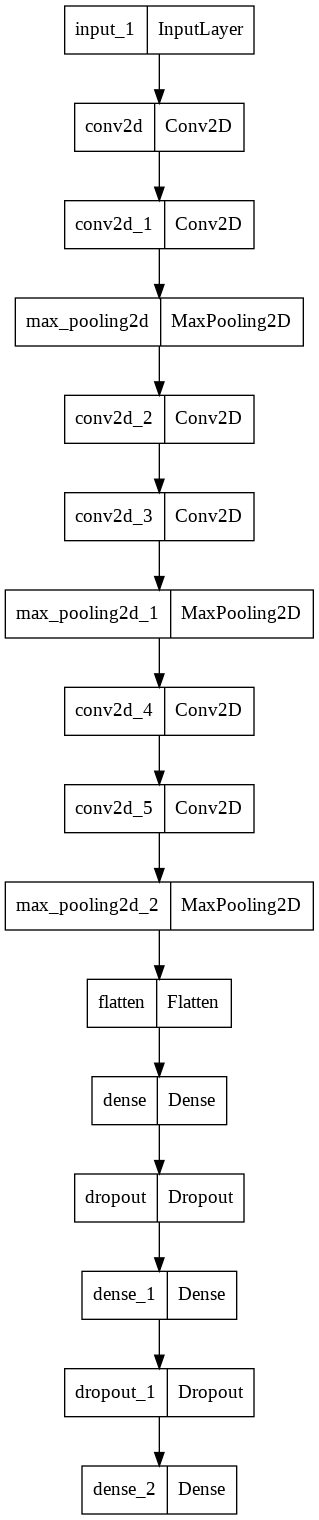

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model_1_version_2)

In [15]:
# Building the Convolutonal Neural Network Model 2 (Version2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model_2_version_2 = Model(inputs=input, outputs = output)
model_2_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_2_version_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_25 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [14]:
# Building the Convolutonal Neural Network Model 3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model_3_version_2 = Model(inputs=input, outputs = output)
model_3_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_3_version_2.summary()
#plot_model(model_3_version_2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 16)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 42, 42, 32)        9248      
                                                           

In [11]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [16]:
# Training the model

history_1_version_2= model_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
2048/2048 [==============================] - 95s 46ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 2/10
2048/2048 [==============================] - 92s 45ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 3/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 4/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 5/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 6/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 7/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 8/10
2048/2048 [==========================

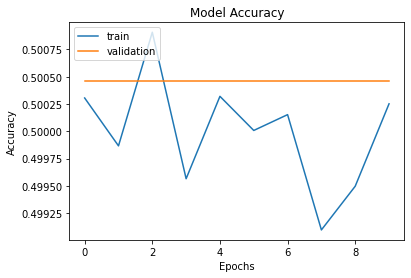

In [17]:
plot_hist(history_1_version_2)

In [18]:
# Training the model

history_2_version_2= model_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
2048/2048 [==============================] - 95s 46ms/step - loss: 0.6944 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 2/10
2048/2048 [==============================] - 92s 45ms/step - loss: 0.6932 - acc: 0.5008 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 3/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 4/10
2048/2048 [==============================] - 92s 45ms/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 5/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 6/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 7/10
2048/2048 [==============================] - 93s 45ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 8/10
2048/2048 [==========================

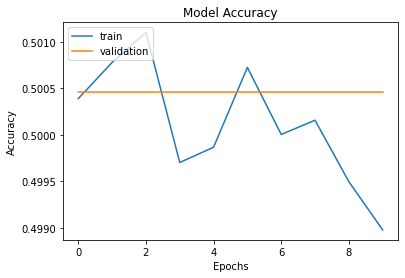

In [19]:
plot_hist(history_2_version_2)

In [24]:
# Training the model

history_3_version_2= model_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
2048/2048 [==============================] - 95s 46ms/step - loss: 0.6933 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 2/10
2048/2048 [==============================] - 93s 46ms/step - loss: 0.6933 - acc: 0.5003 - val_loss: 0.6933 - val_acc: 0.5005
Epoch 3/10
2048/2048 [==============================] - 93s 46ms/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 4/10
2048/2048 [==============================] - 94s 46ms/step - loss: 0.6933 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 5/10
2048/2048 [==============================] - 93s 46ms/step - loss: 0.6933 - acc: 0.5010 - val_loss: 0.6933 - val_acc: 0.5005
Epoch 6/10
2048/2048 [==============================] - 94s 46ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5005
Epoch 7/10
2048/2048 [==============================] - 116s 56ms/step - loss: 0.6933 - acc: 0.5005 - val_loss: 0.6933 - val_acc: 0.5005
Epoch 8/10
2048/2048 [=========================

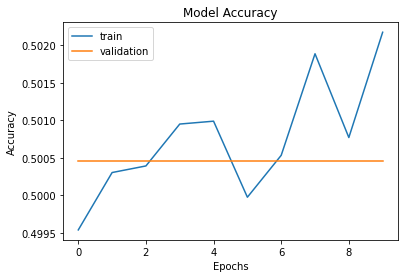

In [25]:
plot_hist(history_3_version_2)

In [22]:
# Testing the models

print("Test dataset accuracy for model 1 version 2 is: {0:.4f}".format(model_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2 version 2 is: {0:.4f}".format(model_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3 version 2 is: {0:.4f}".format(model_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 10s 36ms/step - loss: 0.6931 - acc: 0.5002
Test dataset accuracy for model 1 version 2 is: 0.5002
256/256 [==============================] - 8s 32ms/step - loss: 0.6932 - acc: 0.5002
Test dataset accuracy for model 2 version 2 is: 0.5002
256/256 [==============================] - 8s 32ms/step - loss: 0.6933 - acc: 0.5002
Test dataset accuracy for model 3 version 2 is: 0.5002
